# Principle Component Analysis (PCA) Implementation

#### In this Jupyter notebook, I implement Principal Component Analysis (PCA) from scratch and apply it to a real-world dataset containing gene expression levels across different types of leukemia. The dataset is available at: https://www.kaggle.com/datasets/brunogrisci/leukemia-gene-expression-cumida. 

#### The data contains 64 samples, each with expression values for 22,284 genes, along with a label indicating one of 5 types of leukemia. Because of its high-dimensionality, this dataset is a great candidate for PCA. The large number of features relative to samples means that dimensionality reduction offers to help uncover patterns or clusters in the data based on leukemia type.

#### In this notebook, I will:
#### - Implement PCA manually 
#### - Apply it to the leukemia dataset to reduce its dimensionality to 2, enabling a PCA plot
#### - Visualize the results in 2D, coloring each point by its leukemia type
#### - Plot the explained variance to analyze how much information is captured by the top components

#### And, toward the end, I will compare this PCA-from-scratch result with the output from sklearn.decomposition.PCA, which I previously used in other notebooks. This comparison will help verify that the implementation is correct and behaves as expected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Import & Filter the Data

In [2]:
# Load data
df = pd.read_csv("Leukemia_GSE9476.csv")

# Separate features from labels
X = df.drop("type", axis=1).values  # shape: (64, 22284)
y = df["type"].values

# standardize the data subtract mean and divide by standard deviation (feature-wise)
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

# Avoid division by zero if any gene has zero variance
X_std[X_std == 0] = 1

X_standardized = (X - X_mean) / X_std

## PCA Algorithm - Small Covariance Matrix

In [3]:
# compute the reduced covariance matrix (64 x 64)
n_samples = X_standardized.shape[0]  # = 64
cov_matrix = (1 / (n_samples - 1)) * (X_standardized @ X_standardized.T)

# do an eigen decomposition of the covariance matrix
eigvals, eigvecs = np.linalg.eigh(cov_matrix)

# sort eigenvectors in descending order of eigenvalues
sorted_idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_idx]
eigvecs = eigvecs[:, sorted_idx]

# compute the principal components
V = X_standardized.T @ eigvecs  # shape: (22284, 64)

# normalize columns of V
V = V / np.linalg.norm(V, axis=0)

# project data onto top k principal components
k = 2
W = V[:, :k]                    # projection matrix (22284 x 2)
X_pca = X_standardized @ W     # projected data (64 x 2)

## Result - Small Covariance Matrix

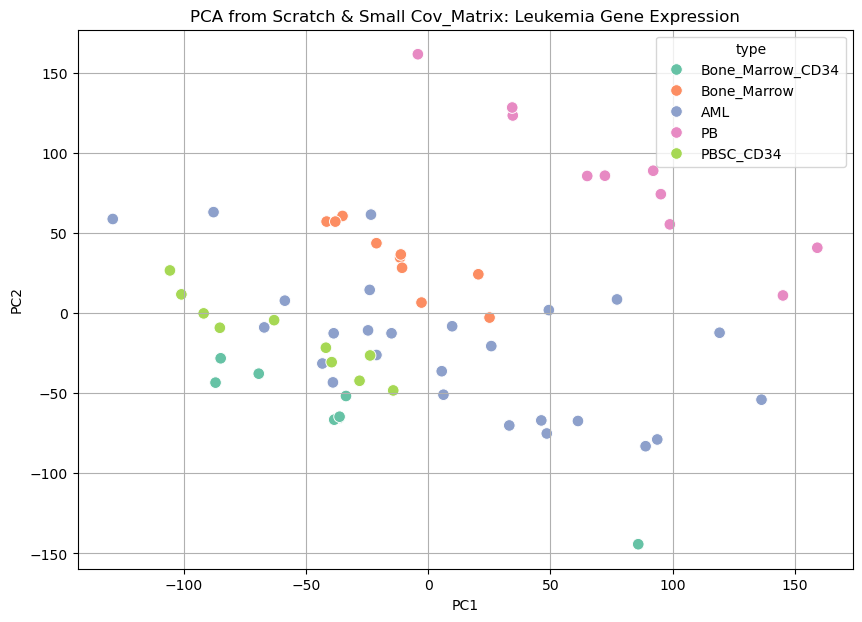

In [4]:
# Put into DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["type"] = y

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="type", palette="Set2", s=70)
plt.title("PCA from Scratch & Small Cov_Matrix: Leukemia Gene Expression")
plt.grid(True)
plt.show()

## Analysis & Discussion

### Plot Explained Variance w/ small covariance matrix
Since we used the reduced covariance matrix, we already have all 64 eigenvalues. Each eigenvalue represents the amount of variance explained by its corresponding principal component, which we can plot. 

In the plot below, I take the sum of all the eigen values to be the total variance in the data. Thus, the explained variance of each eigenvalue is itself divided by this total variance. Then, the cumulative variance, starting with the largest eigenvalues to the smallest, is the sum of all the explained variances summed together of the eigenvalues that are larger than it, so that at the end they will sum to 1.

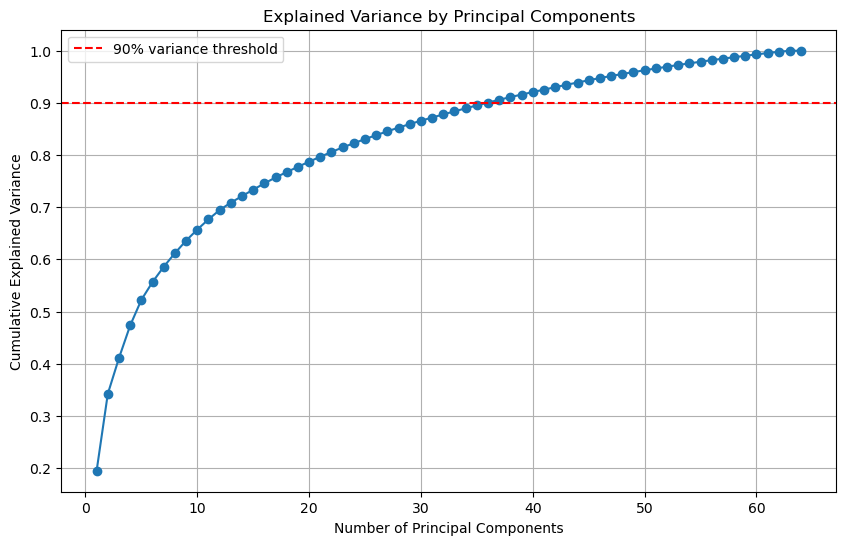

In [12]:
# Total variance
total_variance = np.sum(eigvals)

# Explained variance ratio for each PC
explained_variance_ratio = eigvals / total_variance

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(eigvals) + 1), cumulative_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Principal Components")
plt.grid(True)
plt.axhline(0.90, color='red', linestyle='--', label='90% variance threshold')
plt.legend()
plt.show()


The plot above shows the cumulative explained variance as a function of the number of principal components. The k-th point on the curve tells us how much of the total variance in the dataset is captured when using the top k principal components.

From the graph, we can observe the following:
- The first few components capture a substantial amount of the variance. Notice that the first 10 components already explain around 70% of the total variance.
- To reach 90% cumulative explained variance (the red, dashed line), we need approximately 35–40 components.
- Around the 35th largest principal component, the curve begins to flatten, indicating diminishing returns. Adding more components contributes relatively little to the total variance captured.

This makes sense considering the data was extremely high-dimensional and had to go with gene expression, where a relatively small number of changes can explain most of the variation across samples, while the rest is noise or minor variation.

This analysis can help guide dimensionality reduction choices:
- For visualization, the first 2 or 3 principal components are enough to explain around 35% of the variation.
- For other machine learning tasks, keeping the first 35–40 components would be needed to balance dimensionality reduction with information retention.

## Compare PCA implementation to PCA using scikit-learn
Lastly, I compared the results of my PCA implementation to those produced by scikit-learn’s PCA module. Both methods were applied to the same standardized gene expression dataset, and I focused on projecting the data into the first two principal components to visualize the five types of leukemia.

In [13]:
# Fit PCA
pca = PCA(n_components=2)
X_sklearn_pca = pca.fit_transform(X_scaled)

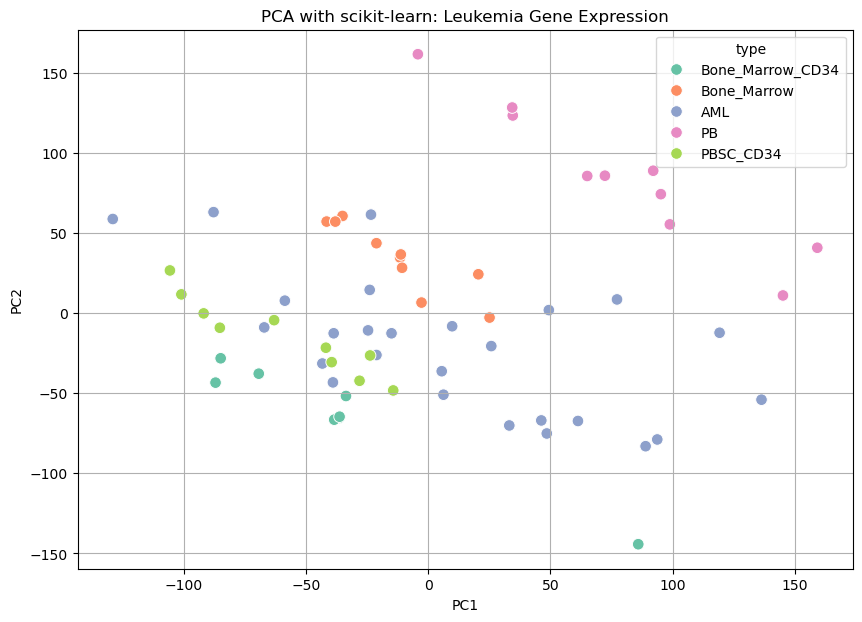

In [14]:
# DataFrame for plotting
df_sklearn_pca = pd.DataFrame(X_sklearn_pca, columns=["PC1", "PC2"])
df_sklearn_pca["type"] = y

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_sklearn_pca, x="PC1", y="PC2", hue="type", palette="Set2", s=70)
plt.title("PCA with scikit-learn: Leukemia Gene Expression")
plt.grid(True)
plt.show()

The 2D scatterplots generated from each approach are visually very similar (perhaps identical), showing comparable clustering patterns and separation between certain leukemia types. This confirms that the eigen-decomposition of the reduced covariance matrix in my custom implementation correctly identifies the directions of maximum variance, just as the optimized scikit-learn function does.

In addition, the explained variance ratios for each principal component match closely between the two methods. This was further validated (see below) by plotting the cumulative explained variance using scikit-learn, which showed that approximately 35 to 40 components are needed to capture 90% of the dataset’s variance — a result consistent with the eigenvalues my implementation computes.

### Pot Explained Variance w/ Scikit-learn PCA package

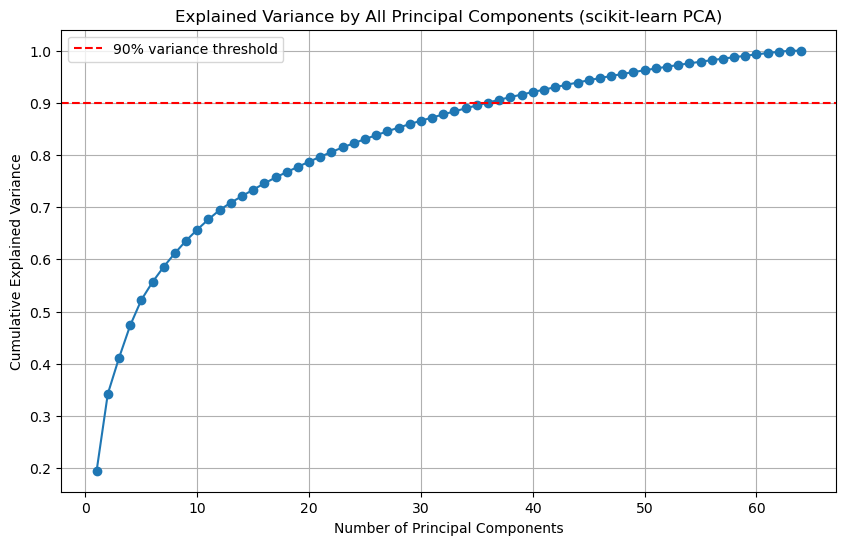

In [18]:
# Rescale if not already done
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA with all components
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Get explained variance ratios
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by All Principal Components (scikit-learn PCA)")
plt.grid(True)
plt.axhline(0.90, color='red', linestyle='--', label='90% variance threshold')
plt.legend()
plt.show()
